<a href="https://colab.research.google.com/github/JiananAlvin/ee411_fundamentals_of_inference_and_learning/blob/main/FoIL_ex13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

# Deep learning tips and tricks: Data augmentation and Transfer learning

**What you will learn today**: You will learn how to improve the performance of a deep neural network by increasing the effective data available for training using data augmentation. You will also learn how to leverage large pretrained models to boost the performance of a downstream task using transfer learning.

## On the previous episode...

On the previous lab we explored different techniques to train neural networks and implemented them using `PyTorch`. Our experiments showed that choosing the right learning rate and architecture are fundamental to generalize on a complex dataset such as CIFAR10. We learned how modern optimizers work, and explored new architectural concepts such as batch normalization and skip connections.

In this lab, we will continue this journey and investigate other techniques to improve performance of a neural network. In particular, we will see how one can exploit the flexibility of stochastic gradient descent to increase our effective data available, and how we can leverage large pretrained models to initialize our networks in a smart way.

Specifically, we will talk about:
* Data augmentation
* Transfer learning

So... let's get started!


For convenience, we copy-paste the necessary code from the previous lab.

For every model we want to create, we will create a new class that inherits `BasicModel` and implemements the `__init__` and `forward` functions.

# Data augmentation
Data augmentation is a training technique which consists in transforming every batch of data shown to the model using some random operation which generates a new ''view'' of each sample that retains its semantic information. For example, in the context of image classification, the label of most objects remains the same if you mirror them horizontally. Therefore, a cheap way to increase your training data, is to ''augment'' each sample by introducing its mirrored counterpart.

Let's do it!

In [13]:
# first we load all the necessary libraries
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

from training_utils import fit, predict, plot_loss, visualize_images

In `PyTorch`, the data augmentation operations are included in the transformation pipeline of a dataset. You can find more details on the [official documentation](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip() # We want to randomly apply a random flip to every sample
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In `PyTorch`, any `nn.Module` can be included in a transform pipeline. Every time you ask for a sample `x`, `PyTorch` calls `transform.forward(x)` before feeding it to the model. This means we can easily visualize the effect of data augmentation.

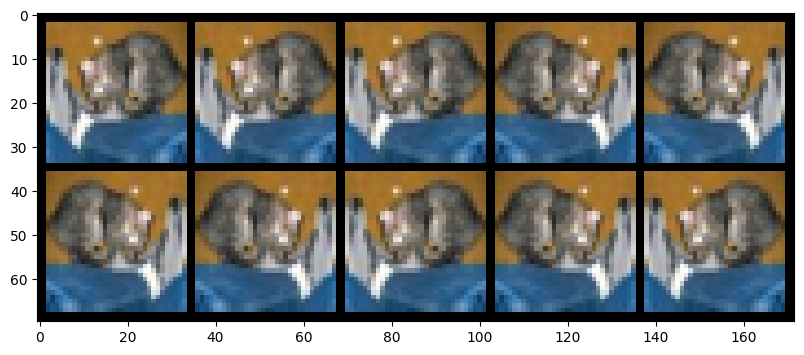

In [ ]:
im, _ = test_dataset[0]
im = im[None, ...] # We need a leading batch dimension to feed to the model

images_rot = torch.cat([T.RandomHorizontalFlip()(im) for _ in range(10)])

grid = torchvision.utils.make_grid(images_rot, nrow=5, padding=2)
# Just normalization for test data
plt.figure(figsize=(20,4))
plt.imshow(grid.permute([1,2,0]))

Horizontal flips are a bit obvious. We can get more creative with data augmentation. However, bare in mind that some transformations might destroy important information of your data, so be careful when applying it.

CIFAR10 is relatively easy, so the following transformations are enough to achieve good performance.

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=[32,32], padding=4)
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=test_transform)

# we make the Batch_sizes smaller for computational reasons
# we will later use larger models and memory might become an issue
BATCH_SIZE = 256

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Let's train a **ResNet**! Since it is a standard model, it is already implemented in the `torchvision` library and we can use it directly.

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.resnet import resnet18

model = resnet18(num_classes=10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )
)

# predict with the trained model
predict(
        model,
        test_dataloader = test_dataloader,
        device = DEVICE,
    )

# Transfer learning

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Transfer learning refers to the concept of initializing a neural network using the weights learned on a different task before training. Surprisingly, if the pretraining dataset is large enough, but also semantically ''close'' to the downstream task, using transfer learning, instead of regular training from random weights can significantly boost performance. Intuitively, transfer learning allows to recycle the features learned with a lot of data on the pretraining task, and leverage them to classify a new dataset.

Let's see this in practice. To that end, we will follow the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which is an excellent resource to learn how to implement advanced techniques in deep learning. We will minimally adapt the code to fit our streamlined API from the previous labs.

Let's download our data...

In [7]:
import requests
import os

remote_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

local_file = './data/hymenoptera_data.zip'
os.makedirs('./data', exist_ok=True)

data = requests.get(remote_url)

# Save file data to local copy
with open(local_file, 'wb')as file:
    file.write(data.content)

and extract it...

In [8]:
from zipfile import ZipFile

# opening the zip file in READ mode
with ZipFile(local_file, 'r') as zip:
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('./data')
    print('Done!')

Extracting all the files now...
Done!


We can work with this data directly using `torchvision`

In [9]:
# Data augmentation and normalization for training
# The normalization values are the average and std of each channel, precomputed
# on the training images
train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for test data
test_transform =  T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Same normalization as train data
])


data_dir = 'data/hymenoptera_data'
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), test_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

train_size = len(train_dataset)
test_size = len(test_dataset)
class_names = train_dataset.classes

Let's visualize a few images

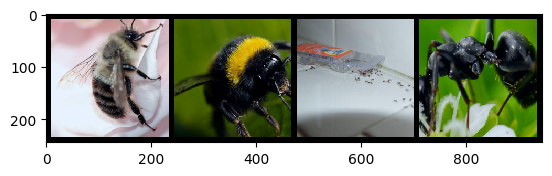

In [14]:
visualize_images(
    train_dataloader,
    mean=torch.tensor([0.485, 0.456, 0.406]),
    std=torch.tensor([0.229, 0.224, 0.225]),
)

There are two major transfer learning techniques depending on which parts of the network are updated using the new data:
1. Finetuning the full network
2. Finetuning only the last layer

First let's see how a randomly initialized model performs!

In [ ]:
# the model is a resnet18. How many outputs should it have?
model = resnet18(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the full network
Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. The rest of the training looks as usual, albeit normally using a significantly smaller learning rate.


In [ ]:
import torch.nn as nn
from torchvision.models import resnet18

class FinetuningLastLayer(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # Load the pretrained ResNet18 model
        self.network = resnet18(pretrained=True)

        # Freeze all the parameters of the network
        for param in self.network.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with a new one
        # Randomly initialize it with `num_classes` number of output neurons
        num_features = self.network.fc.in_features  # Get the number of input features of the last layer
        self.network.fc = nn.Linear(num_features, num_classes)  # Replace the last layer with a new one

    def forward(self, x):
        return self.network(x)

Let's train it...

In [ ]:
model = FinetuningFullModel(num_classes=...).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the last layer

Sometimes finetuning all the parameters of a large model is too expensive, or unstable. In those cases, one can alternatively 'freeze' some parts of the network, and train only the latter parts. Most often, just tuning the last layer is enough to get good enough results, with the optimal performance normally achieved by finetuning a few of the last layers.

In [15]:
import torch.nn as nn
from torchvision.models import resnet18

class FinetuningLastLayer(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # Load the pretrained ResNet18 model
        self.network = resnet18(pretrained=True)

        # Freeze all the parameters of the network
        for param in self.network.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with a new one
        # Randomly initialize it with `num_classes` number of output neurons
        num_features = self.network.fc.in_features  # Get the number of input features of the last layer
        self.network.fc = nn.Linear(num_features, num_classes)  # Replace the last layer with a new one

    def forward(self, x):
        return self.network(x)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Epoch 0: Loss=0.6597927692727964
Epoch 1: Loss=0.6532875662211513
Epoch 2: Loss=0.415980143594693
Epoch 3: Loss=0.3154806210125079
Epoch 4: Loss=0.5056271044018327
Epoch 5: Loss=0.3477798460746092
Epoch 6: Loss=0.4705979282983014
Epoch 7: Loss=0.42030457475940225
Epoch 8: Loss=0.5184255159902768
Epoch 9: Loss=0.3897483082961474
Epoch 10: Loss=0.3964107999211696
Epoch 11: Loss=0.5124150849268084
Epoch 12: Loss=0.4324945321184446
Epoch 13: Loss=0.6069909158376519
Epoch 14: Loss=0.3972742603023033
Epoch 15: Loss=0.3986764614027543
Epoch 16: Loss=0.48682290524030564
Epoch 17: Loss=0.36858625132895884
Epoch 18: Loss=0.4834119104703919
Epoch 19: Loss=0.4255354225513388
Epoch 20: Loss=0.6865175650989424
Epoch 21: Loss=0.4297100490905711
Epoch 22: Loss=0.41238407504393676
Epoch 23: Loss=0.43953756242990494
Epoch 24: Loss=0.40164186492501225
Test set: Avg. loss: 0.2383, Accuracy: 145/153 (95%)


(0.2383018070588412, tensor(94.7712, device='cuda:0'))

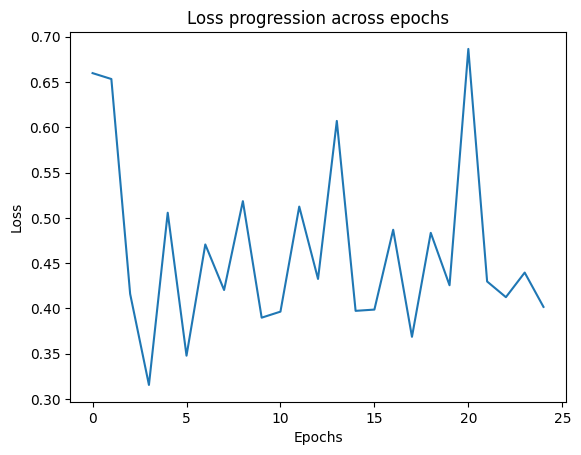

In [16]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from training_utils import fit, predict, plot_loss, visualize_images

# Initialize the model
num_classes = 2  # For example, binary classification
model = FinetuningLastLayer(num_classes=num_classes).to(DEVICE)

# Define the optimizer (only for the last layer since others are frozen)
optimizer = torch.optim.SGD(model.network.fc.parameters(), lr=0.001, momentum=0.9)

# Train the model
plot_loss(
    fit(
        model,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        epochs=25,
        device=DEVICE
    )
)

# Evaluate the model on the test set
predict(
    model,
    test_dataloader=test_dataloader,
    device=DEVICE
)